In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sys import getsizeof
import json
from sqlalchemy import create_engine
import datetime as dt
import ast
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 0)

%matplotlib inline

In [3]:
df_rest_yelp_and_ins = pd.read_csv('../Data/Restaurants_cleaned_inspe_with_yelp.csv',index_col=0)

df_rest_yelp_and_ins.drop(columns=df_rest_yelp_and_ins.iloc[:,0:18].columns.to_list()+['resultdttm','result'],inplace=True)


In [4]:
features = ['historic_routine_ins_count', 'most_recent_previous_ins', 'passed_ins_ratio', 'failed_ins_ratio',]
target = 'target'

X = df_rest_yelp_and_ins[features]
y = df_rest_yelp_and_ins[target]

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [6]:
#dummy model baseline
y.value_counts()/len(y)

0.0    0.771472
1.0    0.228528
Name: target, dtype: float64

In [7]:
def class_model(X, y, model, params = {}, cross_val = 1):
    
    if cross_val == 1: 
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)
        
        pred_model = model(**params)
        pred_model.fit(X_train,y_train)

        y_train_pred = pred_model.predict(X_train)
        y_test_pred = pred_model.predict(X_test)
        print(f"Printing scores for data trained on a {model()}.")
        print(f"Test Score: {pred_model.score(X_test,y_test):,.2f}")
        print(f"Train Score: {pred_model.score(X_train,y_train):,.2f}")
        
        print(classification_report(y_test,y_test_pred))
        print("-------")
        return pred_model

#### Baseline Models, to compare against at the end

In [14]:
baseline_rfc = class_model(X_train_val,y_train_val,RFC,params = {'class_weight':'balanced'});
baseline_logreg = class_model(X_train_val,y_train_val,LogReg)
baseline_knn = class_model(X_train_val,y_train_val,KNC,params = {'n_neighbors':7})
baseline_gbc = class_model(X_train_val,y_train_val,GBC)

Printing scores for data trained on a RandomForestClassifier().
Test Score: 0.66
Train Score: 0.68
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.77       322
         1.0       0.31      0.41      0.35        96

    accuracy                           0.66       418
   macro avg       0.56      0.57      0.56       418
weighted avg       0.69      0.66      0.67       418

-------
Printing scores for data trained on a LogisticRegression().
Test Score: 0.77
Train Score: 0.77
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       322
         1.0       0.00      0.00      0.00        96

    accuracy                           0.77       418
   macro avg       0.39      0.50      0.44       418
weighted avg       0.59      0.77      0.67       418

-------


C:\Users\Navish\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Printing scores for data trained on a KNeighborsClassifier().
Test Score: 0.75
Train Score: 0.77
              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86       322
         1.0       0.33      0.07      0.12        96

    accuracy                           0.75       418
   macro avg       0.55      0.51      0.49       418
weighted avg       0.67      0.75      0.69       418

-------
Printing scores for data trained on a GradientBoostingClassifier().
Test Score: 0.77
Train Score: 0.78
              precision    recall  f1-score   support

         0.0       0.77      0.98      0.87       322
         1.0       0.38      0.03      0.06        96

    accuracy                           0.77       418
   macro avg       0.57      0.51      0.46       418
weighted avg       0.68      0.77      0.68       418

-------


### EDA 

In [16]:
df_rest_yelp_and_ins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2608 entries, 87059 to 27260
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   yelp_id                       2608 non-null   object 
 1   yelp_alias                    2608 non-null   object 
 2   address1                      2607 non-null   object 
 3   url                           2608 non-null   object 
 4   review_count                  2608 non-null   float64
 5   rating                        2608 non-null   float64
 6   price                         2246 non-null   object 
 7   categories                    1026 non-null   object 
 8   businessname                  2608 non-null   object 
 9   dbaname                       17 non-null     object 
 10  legalowner                    1655 non-null   object 
 11  namelast                      2608 non-null   object 
 12  namefirst                     2608 non-null   object 
 13

In [17]:
df_rest_yelp_and_ins.describe()

,review_count,rating,zip,property_id,Latitude,Longitude,historic_routine_ins_count,most_recent_previous_ins,failed_ins_count,passed_ins_count,2nd_most_recent_previous_ins,passed_ins_ratio,failed_ins_ratio,target
count,2608.000000,2608.000000,2608.000000,2257.000000,1888.000000,1888.000000,2608.000000,2608.000000,2608.000000,2608.000000,2589.000000,2608.000000,2608.000000,2608.000000
mean,175.515721,3.456672,2129.974693,158536.596810,42.337174,-71.082958,4.066334,0.225460,3.299847,0.766488,0.222093,0.209108,0.790892,0.228528
std,301.338212,0.805882,29.382497,108558.632737,0.029037,0.033751,2.336279,0.417965,2.285486,0.999192,0.415734,0.286133,0.286133,0.419965
min,1.000000,1.000000,2108.000000,0.000000,42.237125,-71.172610,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,3.000000,2115.000000,82312.000000,42.324138,-71.104476,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.666667,0.000000
50%,70.000000,3.500000,2124.000000,156115.000000,42.348443,-71.074176,4.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,209.250000,4.000000,2131.000000,158292.000000,42.355000,-71.058527,6.000000,0.000000,5.000000,1.000000,0.000000,0.333333,1.000000,0.000000
max,5085.000000,5.000000,2467.000000,437351.000000,42.395173,-70.996730,13.000000,1.000000,13.000000,7.000000,1.000000,1.000000,1.000000,1.000000


Based on domain research & the above table, the following variables will be explored & definitely used: **'review_count','rating', 'price', '2nd_most_recent_previous_ins',** and **'licensecat'.**  
Other variables that will be examined and possibly used are **'categories','issdttm', 'expdttm',** and **variables concerning geographical location.**

In [18]:
df_rest_yelp_and_ins.nunique()

# df_rest_yelp_and_ins.dbaname.value_counts()

yelp_id                         2444
yelp_alias                      2444
address1                        2163
url                             2444
review_count                     600
rating                             9
price                              4
categories                       157
businessname                    2292
dbaname                           17
legalowner                      1222
namelast                        2222
namefirst                       1144
issdttm                         2608
expdttm                            5
licstatus                          2
licensecat                         4
descript                           4
address                         2193
city                              34
state                              3
zip                               33
property_id                     1940
location                        1623
Latitude                        1564
Longitude                       1584
historic_routine_ins_count        13
m

The following columns are being dropped as they have a high number of unique string values that most likely will have no predictive power towards the target variable.  
Columnns: **'dbaname','legalowner','legalowner','namelast',and 'namefirst'**  
Additionally, **'state'** is also dropped as its same across all entries - 'MA', and would not help with unique identification of rows either.

In [9]:
df_eda = df_rest_yelp_and_ins.drop(columns = ['dbaname','legalowner','legalowner','namelast','namefirst','state'])

### Review Count

target
0.0    175.713221
1.0    174.848993
Name: review_count, dtype: float64

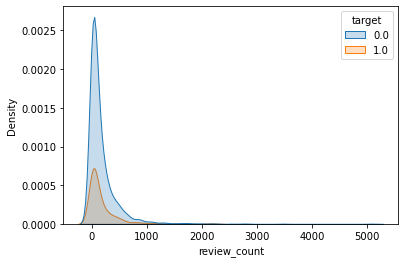

In [10]:
sns.kdeplot(x='review_count',data=df_eda, hue='target',fill=True)
df_eda.groupby(['target',]).review_count.mean()

review_count
(0.999, 5.0]       0.231544
(5.0, 13.0]        0.234783
(13.0, 26.0]       0.298893
(26.0, 43.0]       0.223108
(43.0, 70.0]       0.179688
(70.0, 109.0]      0.233083
(109.0, 170.9]     0.197628
(170.9, 264.6]     0.210728
(264.6, 463.6]     0.233716
(463.6, 5085.0]    0.237548
Name: target, dtype: float64

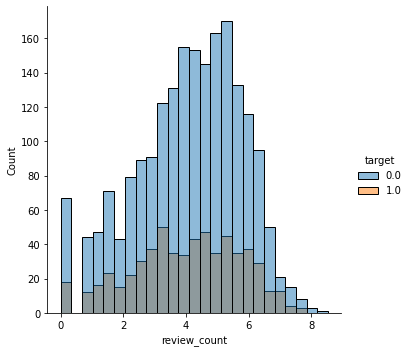

In [11]:
sns.displot(x=np.log(df_eda.review_count),hue=df_eda.target)
# plt.xlim(0,1000)
df_eda.groupby(pd.qcut(x=df_eda.review_count,q=10)).target.mean()

In [12]:
df_eda.sort_values(by='review_count',ascending=False).head(5)

,yelp_id,yelp_alias,address1,url,review_count,rating,price,categories,businessname,issdttm,expdttm,licstatus,licensecat,descript,address,city,zip,property_id,location,Latitude,Longitude,historic_routine_ins_count,most_recent_previous_ins,failed_ins_count,passed_ins_count,2nd_most_recent_previous_ins,passed_ins_ratio,failed_ins_ratio,target
licenseno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23410,y2w6rFaO0XEiG5mFfOsiFA,neptune-oyster-boston,63 Salem St,https://www.yelp.com/biz/neptune-oyster-boston...,5085.0,4.5,$$$,NaN,NEPTUNE RESTAURANT,2012-01-05 11:24:28,2020-12-31 23:59:00,Active,FS,Eating & Drinking,63 Salem ST,Boston,2113,121913.0,"(42.363230000, -71.055940000)",42.363230,-71.055940,6,0.0,5,1,0.0,0.166667,0.833333,0.0
416786,2u_w3rthRzR2uEihW5BC4A,giacomos-ristorante-boston-boston,355 Hanover St,https://www.yelp.com/biz/giacomos-ristorante-b...,3481.0,4.0,$$,NaN,Giacomo's Ristorante,2020-01-21 10:04:35,2020-12-31 23:59:00,Active,FS,Eating & Drinking,353 Hanover ST,Boston,2113,155725.0,"(42.364557000, -71.053439000)",42.364557,-71.053439,1,0.0,1,0,NaN,0.000000,1.000000,0.0
19089,Ruq91rmQNweZ78TzKylQMg,union-oyster-house-boston,41 Union St,https://www.yelp.com/biz/union-oyster-house-bo...,2818.0,3.5,$$,NaN,UNION OYSTER HOUSE,2011-12-14 14:11:17,2020-12-31 23:59:00,Active,FS,Eating & Drinking,41 Union ST,Boston,2108,139293.0,"(42.361270000, -71.056880000)",42.361270,-71.056880,7,0.0,6,1,0.0,0.142857,0.857143,0.0
68416,VnuD2cojPTWd3nIHQjnL8w,island-creek-oyster-bar-boston,500 Commonwealth Ave,https://www.yelp.com/biz/island-creek-oyster-b...,2741.0,4.5,$$$,NaN,Island Creek Oyster Bar,2012-02-06 10:11:59,2020-12-31 23:59:00,Active,FS,Eating & Drinking,500 Commonwealth AVE,Boston,2215,157943.0,"(42.348521000, -71.095099000)",42.348521,-71.095099,3,0.0,2,1,1.0,0.333333,0.666667,0.0
75240,AGR_kBvN__I7aTl0rBywAg,atlantic-fish-company-boston-4,761 Boylston St,https://www.yelp.com/biz/atlantic-fish-company...,2551.0,4.0,$$$,NaN,ATLANTIC FISH COMPANY,2012-01-10 13:10:09,2020-12-31 23:59:00,Active,FS,Eating & Drinking,761 Boylston ST,Boston,2116,18393.0,"(42.349350000, -71.081210000)",42.349350,-71.081210,5,1.0,3,2,1.0,0.400000,0.600000,0.0


From the above analysis, **review_count** creates some variation in the target variable. A tree based model should be able to decipher predictions from this.

Additionally, the log of the # of reviews seems to have a normal distribution. hence the feature can be transformed for better predictability

In [13]:
df_eda['review_count_log'] = np.log(df_eda.review_count)

### Rating

In [14]:
df_eda.groupby('rating').target.mean()

rating
1.0    0.205128
1.5    0.181818
2.0    0.232558
2.5    0.241935
3.0    0.227790
3.5    0.210219
4.0    0.216541
4.5    0.287273
5.0    0.273810
Name: target, dtype: float64

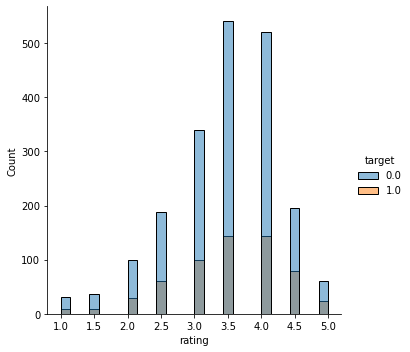

In [15]:
sns.displot(x=df_eda.rating,hue=df_eda.target)

The rating column can be kept as is with no transformation. Primarily, it looks like a very low rated restaurant is more likely to fail the inspection. But beyond that too, a restaurant is almost always more likely to fail the inspection.

### Price

In [30]:
df_eda.groupby('price',dropna=False).target.agg(['count','mean'])

,count,mean
price,,
$,997,0.227683
$$,1052,0.212928
$$$,170,0.305882
$$$$,27,0.296296
NaN,362,0.234807


The **Price** variable needs to be imputed to fill the NaN values & be converted into binary dummy columns.  

Since the number of possible distinct values for price is limited to just 4 options, the above imputation can be undertaken here.

Since '$' can mean other operational things, it will be substituted with Price 1, Price 2.. so on.

In [16]:
df_eda['price'] = df_eda.price.map({'$':'Price_1','$$':'Price_2','$$$':'Price_3','$$$$':'Price_4',})

In [17]:
mode_price = df_eda.price.value_counts().idxmax()
df_eda['price'] = df_eda.price.fillna(value=mode_price)

df_eda = df_eda.join(pd.get_dummies(df_eda.price),how='inner')

In [18]:
df_eda.price.value_counts()

Price_2    1414
Price_1     997
Price_3     170
Price_4      27
Name: price, dtype: int64

### Second Most Recent Inspection (2nd_most_recent_previous_ins)


In [19]:
df_eda.groupby(['2nd_most_recent_previous_ins'],dropna=False).target.agg(['count','mean'])

,count,mean
2nd_most_recent_previous_ins,,
0.0,2014,0.208044
1.0,575,0.306087
NaN,19,0.052632


Since there are only a few entries with no inspections 2 periods ago, the rows will be dropped.  
If a restaurant in practice has lesser inspections, a different model can be used for its inspection outcome predictions.

In [20]:
df_eda.dropna(subset=['2nd_most_recent_previous_ins'],inplace=True)

In [21]:
df_eda['2nd_most_recent_previous_ins'].isna().sum()

0

In [37]:
df_eda.groupby(['2nd_most_recent_previous_ins'],dropna=False).target.agg(['count','mean'])

,count,mean
2nd_most_recent_previous_ins,,
0.0,2014,0.208044
1.0,575,0.306087


### License Category (licensecat / descript)

In [38]:
df_eda.columns

Index(['yelp_id', 'yelp_alias', 'address1', 'url', 'review_count', 'rating',
       'price', 'categories', 'businessname', 'issdttm', 'expdttm',
       'licstatus', 'licensecat', 'descript', 'address', 'city', 'zip',
       'property_id', 'location', 'Latitude', 'Longitude',
       'historic_routine_ins_count', 'most_recent_previous_ins',
       'failed_ins_count', 'passed_ins_count', '2nd_most_recent_previous_ins',
       'passed_ins_ratio', 'failed_ins_ratio', 'target', 'review_count_log',
       'Price_1', 'Price_2', 'Price_3', 'Price_4'],
      dtype='object')

In [39]:
df_eda.groupby('descript',dropna=False).target.agg(['count','mean'])

,count,mean
descript,,
Eating & Drinking,1339,0.215086
Eating & Drinking w/ Take Out,969,0.221878
Mobile Food Walk On,5,0.400000
Retail Food,276,0.326087


Likewise, the licensecat columns need to be encoded into dummy variables. Since the 4 categories are fixed and a restaurant always has to have a category, these values can be imputed right now.

In [41]:
df_eda.shape

(2589, 34)

In [42]:
df_eda = df_eda.join(pd.get_dummies(df_eda.licensecat),how='inner')
df_eda.head()

,yelp_id,yelp_alias,address1,url,review_count,rating,price,categories,businessname,issdttm,expdttm,licstatus,licensecat,descript,address,city,zip,property_id,location,Latitude,Longitude,historic_routine_ins_count,most_recent_previous_ins,failed_ins_count,passed_ins_count,2nd_most_recent_previous_ins,passed_ins_ratio,failed_ins_ratio,target,review_count_log,Price_1,Price_2,Price_3,Price_4,FS,FT,MFW,RF
licenseno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87059,BdHONnZzNFUdwQJbpuOd_A,100-delicias-roslindale-4,635 Hyde Park Ave,https://www.yelp.com/biz/100-delicias-roslinda...,37.0,2.0,Price_2,"{'alias': 'noodles', 'title': 'Noodles'}",100 Percent Delicia Food,2013-04-05 12:47:23,2020-12-31 23:59:00,Active,FS,Eating & Drinking,635 Hyde Park AVE,Roslindale,2131,77476.0,"(42.278590000, -71.119440000)",42.278590,-71.119440,5,0.0,5,0,0.0,0.0,1.0,1.0,3.610918,0,1,0,0,1,0,0,0
351943,dAolyz6VhWLFnpltqOWp1w,100-delicias-express-jamaica-plain,660A Centre St,https://www.yelp.com/biz/100-delicias-express-...,26.0,4.0,Price_2,"{'alias': 'noodles', 'title': 'Noodles'}",100 Percent Delicias Express,2018-11-26 09:59:52,2020-12-31 23:59:00,Active,FT,Eating & Drinking w/ Take Out,656 Centre ST,Jamaica Plain,2130,28152.0,"(42.312830000, -71.113860000)",42.312830,-71.113860,2,0.0,2,0,0.0,0.0,1.0,0.0,3.258097,0,1,0,0,0,1,0,0
313440,_LLIO1lyRW2pu8q_AkUo5g,1000-degrees-neapolitan-pizzeria-boston-4,45 Court St,https://www.yelp.com/biz/1000-degrees-neapolit...,35.0,3.5,Price_2,"{'alias': 'pizza', 'title': 'Pizza'}",1000 Degrees Pizza,2017-08-14 08:49:37,2019-12-31 23:59:00,Inactive,FS,Eating & Drinking,55 Court ST,Boston,2108,156226.0,"(42.359227000, -71.058878000)",42.359227,-71.058878,2,1.0,1,1,0.0,0.5,0.5,1.0,3.555348,0,1,0,0,1,0,0,0
27609,BXlYwqIWf8m7qk1RFMKCeQ,163-vietnamese-sandwiches-and-bubble-tea-boston,66 Harrison Ave,https://www.yelp.com/biz/163-vietnamese-sandwi...,337.0,3.5,Price_1,"{'alias': 'noodles', 'title': 'Noodles'}",163 Vietnamese Sandwich,2011-12-15 12:51:38,2020-12-31 23:59:00,Active,FS,Eating & Drinking,66 Harrison AV,BOSTON,2111,NaN,NaN,NaN,NaN,4,0.0,4,0,0.0,0.0,1.0,0.0,5.820083,1,0,0,0,1,0,0,0
18671,yv99L9NjxNb5hLVCy01ZCw,twentieth-century-bowling-lanes-hyde-park-2,1231 Hyde Park Ave,https://www.yelp.com/biz/twentieth-century-bow...,1.0,5.0,Price_2,"{'alias': 'bowling', 'title': 'Bowling'}",20TH CENTRY BOWLING LANES,2012-01-25 13:39:22,2020-12-31 23:59:00,Active,FT,Eating & Drinking w/ Take Out,1231 Hyde Park AVE,Hyde Park,2136,77089.0,"(42.256820000, -71.124110000)",42.256820,-71.124110,1,0.0,1,0,1.0,0.0,1.0,0.0,0.000000,0,1,0,0,0,1,0,0


### Categories

In [43]:
df_eda['categories_clean'] = df_eda.categories.map(ast.literal_eval,na_action='ignore').map(lambda x: x.get('title'),na_action='ignore')

There are 133 unique values; and none of the high quantity ones have a particular trend of the target variable changing as the category changes. Morever, there are 1372 nan values.  
Hence, this column will be ignored for the moment.

### License Dates ('issdttm' & 'expdttm')

In [60]:
df_eda['issdttm'] = pd.to_datetime(df_eda.issdttm)
df_eda['expdttm'] = pd.to_datetime(df_eda.expdttm)
df_eda['license_issue_since'] = df_eda.issdttm.map(lambda x: dt.datetime.now() - x).dt.days
df_eda['license_expiry_left'] = df_eda.expdttm.map(lambda x: x - dt.datetime.now()).dt.days

<AxesSubplot:xlabel='license_issue_since', ylabel='Density'>

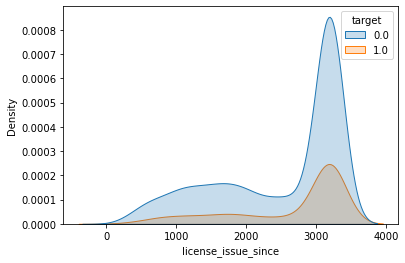

In [61]:
sns.kdeplot(x='license_issue_since',data=df_eda,hue='target',fill=True)

In [55]:
pd.qcut(x=df_eda.license_issue_since,q=10).value_counts()

(3155.0, 3178.0]     302
(3217.0, 3237.0]     273
(1584.4, 2054.0]     264
(2757.8, 3155.0]     260
(1077.6, 1584.4]     259
(242.999, 1077.6]    259
(3199.0, 3217.0]     258
(2054.0, 2757.8]     254
(3237.0, 3286.0]     242
(3178.0, 3199.0]     218
Name: license_issue_since, dtype: int64

In [56]:
df_eda.groupby(pd.qcut(x=df_eda.license_issue_since,q=10)).target.mean()

license_issue_since
(242.999, 1077.6]    0.185328
(1077.6, 1584.4]     0.181467
(1584.4, 2054.0]     0.215909
(2054.0, 2757.8]     0.196850
(2757.8, 3155.0]     0.242308
(3155.0, 3178.0]     0.235099
(3178.0, 3199.0]     0.311927
(3199.0, 3217.0]     0.236434
(3217.0, 3237.0]     0.227106
(3237.0, 3286.0]     0.280992
Name: target, dtype: float64

Not sure if there is anything here. The longer a restaurant has held a license, it may or may not be better or worse with inspections. 

### Geographical Location

There are multiple ways provided to identify geographical locations. The question comes down to how best club the data together. 

In [62]:
df_eda.groupby('zip').target.agg(['count','mean']).sort_values(by='count')

,count,mean
zip,,
2163,1,0.000000
2140,1,1.000000
2117,1,0.000000
2467,3,0.666667
2201,4,0.000000
2199,28,0.392857
2129,32,0.187500
2121,41,0.097561
2126,44,0.068182


The geographical locations could be useful, but shall be incorporated only if the predictive power is poor from the other factors. Since there are quite a few of them, which would balloon up the number of features when representated as dummy variables or additional research would have to be done to determine how they can be grouped together. 

----

At the moment, we will use the following features:
 '''
 **'review_count',
 'rating',
 'historic_routine_ins_count',
 'most_recent_previous_ins',
 'failed_ins_count',
 'passed_ins_count',
 '2nd_most_recent_previous_ins',
 'passed_ins_ratio',
 'failed_ins_ratio',
 'Price_1',
 'Price_2',
 'Price_3',
 'Price_4',
 'FS',
 'FT',
 'MFW',
 'RF',
 'license_issue_since'.**  
These features will be engineered as necessary to help arrive at a final model. 

In [58]:
df_eda.columns

Index(['yelp_id', 'yelp_alias', 'address1', 'url', 'review_count', 'rating',
       'price', 'categories', 'businessname', 'issdttm', 'expdttm',
       'licstatus', 'licensecat', 'descript', 'address', 'city', 'zip',
       'property_id', 'location', 'Latitude', 'Longitude',
       'historic_routine_ins_count', 'most_recent_previous_ins',
       'failed_ins_count', 'passed_ins_count', '2nd_most_recent_previous_ins',
       'passed_ins_ratio', 'failed_ins_ratio', 'target', 'review_count_log',
       'Price_1', 'Price_2', 'Price_3', 'Price_4', 'FS', 'FT', 'MFW', 'RF',
       'categories_clean', 'license_issue_since', 'license_expiry_left'],
      dtype='object')

In [63]:
df_eda.to_csv("rest_post_eda.csv")